# Transverse Field Ising Model

Dependancies for this notebook:

In [1]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector, Pauli
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate

from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit.circuit.library import QFT

Methods used in this notebook:

In [153]:
def create_hamiltonian(ancilla_bits, eigen_bits, g):
    H = np.zeros((2**eigen_bits, 2**eigen_bits), dtype=np.complex128)

    # construct the Hamiltonian
    # with Pauli Operators in Qiskit ^ represents a tensor product
    print("H = ", end='')
    for i in range(eigen_bits-1):
        temp = Pauli('')
        for j in range(eigen_bits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        print("-"+str(temp)+" ", end='')
        H += -temp.to_matrix()
    for i in range(eigen_bits):
        temp = Pauli('')
        for j in range(eigen_bits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        print("-"+str(g)+"*"+str(temp)+" ", end='')
        H += -g*temp.to_matrix()
    print("\n")
    
    # normalize the Hamiltonian
    H = (1/8)*H/np.linalg.norm(H, ord=2)
    
    # rotate matrix so that it will be positive definite
    H += 1/2*np.eye(2**eigen_bits)
    
    print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
    min_eigenvalue = np.min(np.linalg.eigvals(H))
    print("\nLowest energy Eigenvalue", min_eigenvalue)
    
    # convert revolutions to radians
    H *= 2*np.pi*1j
    
    # convert the rotations to complex numbers
    H = expm(H)
    return H

def get_distribution(qc):
    ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
    new_dist = {}
    for key in ideal_distribution:
        bin_num = key[eigen_bits:]
        try:
            new_dist[bin_num] += ideal_distribution[key]
        except:
            new_dist[bin_num] = ideal_distribution[key]
    return new_dist
def create_graph(qc, g):
    ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
    new_dist = {}
    for key in ideal_distribution:
        bin_num = key[eigen_bits:]
        try:
            new_dist[bin_num] += ideal_distribution[key]
        except:
            new_dist[bin_num] = ideal_distribution[key]
    # print(new_dist)
    fig,ax = plt.subplots()
    plt.xticks(rotation=90)
    plt.ylabel("Probability")
    plt.xlabel("Binary String")
    plt.title("QPE estimating TFIM with g="+str(g))
    plt.ylim([0,1.1])
    bar = ax.bar(new_dist.keys(), new_dist.values())
    plt.show()
def get_phase_from(qc, quiet=False):
    ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
    max_num = 0
    binary_num = ''
    for key in ideal_distribution:
        if (ideal_distribution[key] > max_num):
            max_num = ideal_distribution[key]
            binary_num = key
            
    binary_num = binary_num[eigen_bits:]
    decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

    if not quiet:
        # print("Lowest energy Eigenvalue", min_eigenvalue.real)
        print("Binary Number Output: 0."+str(binary_num))
        print("Decimal Number with Equivalent Value:",decimal_num)
    return decimal_num

## Table of Contents

* Background


## Overview
The transverse-field Ising model (TFIM) is a representation of multiple spinors coupled to their nearest neighbors with an external magnetic field. Each particle's spin is either aligned or anti-aligned with the $z$ axis with the magnetic field perpendicular to that spin along the $x$ axis.

Let $n\in\mathbb{N}$ and $g\in\mathbb{R}_{\geq 0}$, the governing matrix $H\in \mathbb{C}^{2^n \times 2^n}$ (the Hamiltonian) of the one dimensional transverse-field Ising model with open boundary conditions is given by
\begin{equation}
    H = -\sum_{i=0}^{n-1} Z_iZ_{i+1} - g\sum_{i=0}^nX_i,
\end{equation}
where $Z_i$ represents the Pauli-Z operator applied to the $i$th particle and $X_i$ represents the Pauli-X operator applied to the $i$th particle.
    
The physical interpretation of the TFIM as defined above, is that $n$ describes the number of particles exposed to the transverse external magnetic field. The first term represents the nearest-neighbor coupling, while the second term describes the interaction with the magnetic field, where $g$ quantifies its strength.

Considering the free time-dependent Schrödinger equation governing the dynamics of physical systems and models such as the TFIM, 
\begin{equation}
     i \frac{\partial}{\partial t} |\psi(t) \rangle = H |\psi(t) \rangle
\end{equation} with initial condition
\begin{equation}
    |\psi(t=0)\rangle = |\psi_0\rangle,
\end{equation}
solutions for $|\psi(t) \rangle$ are of the form,
\begin{equation}
    |\psi(t) \rangle = e^{-itH}|\psi_0\rangle.
\end{equation}
Therefore, an eigenvalue approximation of $U = e^{-itH}$ can be used to describe the state $|\psi(t) \rangle$. Since $H$ is hermitian and thus $U$ is unitary, the discussed quantum algorithms can be used to compute this eigenvalue approximation.

### Hamiltonian Decomposition
Creating a Hamiltonian operator on a quantum computer in general requires external preprocessing. One method of constructing such an operator is to decompose it into Pauli operators which are trivial to apply on a quantum computer.

Suppose that the Hamiltonian is a sum of two different Pauli operators, e.g.,
\begin{equation}
H = A + B.
\end{equation}
Since $e^{H} \neq e^{A}e^{B}$ unless $A$ and $B$ commute, in general, the Lie Product formula must be applied to encode the matrix $U$, i.e.,
\begin{equation}
e^{-itH} = \lim_{L \to \infty }\left(e^{-itA/L}e^{-itB/L}\right)^L,
\end{equation}
where $L$ is the order of the expansion.
Given the comparably large error contribution of noise to current quantum simulations, it suffices to approximate $U=e^{-itH}$ using a finite-order expansion.

\begin{equation}
            e^{-itH} = \left(e^{-itA/L}e^{-itB/L}\right)^L \implies e^{-itH/L} = e^{-itA/L}e^{-itB/L}  
        \end{equation}
        Before being able to determine the error of such approximation, we first must find the error of a simpler expression. Defining $\delta$ as the difference between the terms in the above equation,
        \begin{equation}
            \delta = \left|e^{-itH/L} - e^{-itA/L}e^{-itB/L}\right|,
        \end{equation}
        Taylor expanding the exponentials,
        \begin{equation}
           \delta = \left|\sum_{k=0}^\infty \frac{1}{k!}\left(-\frac{it}{L}H\right)^k - \sum_{k=0}^\infty \frac{1}{k!}\left(-\frac{it}{L}(A+B)\right)^k\right|
        \end{equation}
        and writing out terms,
        \begin{equation}
            \delta = \left|\frac{1}{0!}(I-I)-\frac{1}{1!}\frac{it}{L}(H-H)+\mathcal{O}\left(\frac{1}{2!}\frac{t^2}{L^2}\left(H-(A+B)^2)\right)\right)\right| = \mathcal{O}\left(\frac{t^2}{L^2}\right).
        \end{equation}
        Returning to determining the error of the finite expansion, let $\epsilon$ be the difference of the first two terms in the original expression, i.e.,   
        \begin{equation}
            \epsilon = \left|e^{-itH}- \left(e^{-itA/L}e^{-itB/L}\right)^L\right|
        \end{equation}
        Notice the $\epsilon$ follows a similar form to $\delta$ but is raised to the power of $L$. Therefore it is safe to assume the order of $\epsilon$ is $L$ times the order of $\delta$. That means to get precision $\epsilon$, 
        \begin{equation}
            \epsilon = \mathcal{O}\left(\frac{t^2}{L}\right) \implies L = \mathcal{O}\left(\frac{t^2}{\epsilon}\right).
        \end{equation}
        Note that even with a perfect decomposition to Pauli operators, there still exists error in simulation as long as the Pauli operators do not commute.

In case of the TFIM however, the Lie-Trotter approximation is exact since the two terms in its system equation commute, making it an important model system for investigating different performances of quantum algorithms. 

### Initialization
Although QPE can determine the phase of any state vector, it is sensitive to the initial guess of the state. This can observed using the Hamiltonian from the TFIM with 4 particles and magnetization constant $g=10$ as shown in \cref{fig:bunchofansatzes}. In each program of QPE all parameters were held constant, but a different gate was applied to the ansatz. Specifically, a $R_y(\theta)$ gate was applied to the ansatz where $\theta$ was varied from 0 to $2\pi$ radians. This rotation puts the qubits into a superposition of zero and one spins states.

In [154]:
eigen_bits = 4
g = 10
ancilla_bits = 4
H = create_hamiltonian(ancilla_bits, eigen_bits, g)
rotation_axis = 'y'

H = -ZZII -IZZI -IIZZ -10*XIII -10*IXII -10*IIXI -10*IIIX 

Eigenvalues of the Hamiltonian:
 [0.625     +0.j 0.375     +0.j 0.55750815+0.j 0.5643727 +0.j
 0.43240364+0.j 0.4394772 +0.j 0.49303095+0.j 0.50696905+0.j
 0.49989549+0.j 0.50010451+0.j 0.56759636+0.j 0.5605228 +0.j
 0.4356273 +0.j 0.44249185+0.j 0.49688085+0.j 0.50311915+0.j]

Lowest energy Eigenvalue (0.37500000000000006+0j)


In [155]:
trials = 100
rot_outputs = []
for angle in np.linspace(0,2*pi, trials):
    qr_ancilla = QuantumRegister(ancilla_bits)
    qr_eigenstate = QuantumRegister(eigen_bits)
    cr = ClassicalRegister(ancilla_bits)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    
    # prepare state
    qc.h(qr_ancilla)
    if rotation_axis == 'x':
        qc.rx(angle, qr_eigenstate)
    if rotation_axis == 'y':
        qc.ry(angle, qr_eigenstate)
    if rotation_axis == 'z':
        qc.rz(angle, qr_eigenstate)
    
    for i in range(ancilla_bits):
        mat = np.linalg.matrix_power(H, 2**(i))
        controlled_U = UnitaryGate(mat).control(annotated="yes")
        qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )
    
    qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
    qc.draw('mpl')
    rot_outputs.append(get_phase_from(qc, quiet=True))

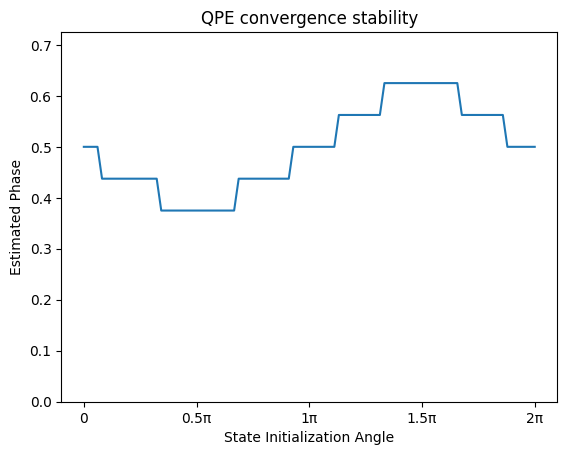

In [156]:
from matplotlib.ticker import FuncFormatter, MultipleLocator

f,ax=plt.subplots(1)
ax.set_title("QPE convergence stability")
ax.set_ylabel("Estimated Phase")
ax.set_xlabel("State Initialization Angle")
ax.plot(np.linspace(0,2*pi, trials), rot_outputs, label = 'ry')
ax.set_ylim([0, max(rot_outputs)+.1])
ax.set_xticks(np.linspace(0,2*pi, 5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda val,pos: '{:g}π'.format(val/np.pi) if val!=0 else '0'))
plt.show()

For QPE to converge stably, a sufficient condition is that the initial guess has a significant overlap with the target state. In the case of the TFIM for different values of $g$, such initializations can be obtained by leveraging physical arguments about the system. More precisely, for small values of $g$, the magnetic field becomes negligible and the coupling term becomes dominant. With only the coupling term affecting the spin, all particles will align in the same way along the $z$-axis, thus initializing all qubits to the zero spin state will have large overlap with the ground energy. Conversely, for large values of $g$, the magnetic field term becomes dominant. Hence, all particles will tend to align with the eigenvectors of the magnetic field. Since the magnetic field is along the $x$-axis, the particles will align with the $x$-basis, i.e., $|+\rangle$ and $|-\rangle$. Thus, the state where its qubits are initialized to zero then go through a Hadamard gate will have a large overlap with the ground state. For an intermediate value of $g$, neither term is negligible, making the initialization challenging. One idea is combine the logic from both guesses. In the case where the magnetic field dominates all qubits are in the $x$-basis and in the case where coupling dominates all qubit's spins are all pointing in the same direction, it follows that when neither term is negligible, the qubits will be close to the same spin close to the $x$ basis. This means that similarly to the case where the magnetic field dominates, the state where a Hadamard gate is applied to every qubit will have sufficient overlap with the ground state. Note that an effective ansatz will be dependent on how much each term contributes to the final energy of the system.

### Simulation
We exemplify the simulation of the TFIM with QPE using a Qiskit emulator for system parameters $n=4$ and $g=0$, $g=1$, and $g=10^{8}$. Following the logic from previous section for the system where the coupling dominates ($g=0$) the qubits in the ansatz will be initialized each to the zero state, the system where the magnetic field dominates ($g=10^8$) every qubit in the ansatz will have a Hadamard gate applied to it, and the state where both terms are non-negligible ($g=1$) the qubits in the ansatz will have a Hadamard gate applied to them.  

In [157]:
eigen_bits = 4
ancilla_bits = 4

g = 0
H = create_hamiltonian(ancilla_bits, eigen_bits, g)

H = -ZZII -IZZI -IIZZ -0*XIII -0*IXII -0*IIXI -0*IIIX 

Eigenvalues of the Hamiltonian:
 [0.375     +0.j 0.45833333+0.j 0.54166667+0.j 0.45833333+0.j
 0.54166667+0.j 0.625     +0.j 0.54166667+0.j 0.45833333+0.j
 0.45833333+0.j 0.54166667+0.j 0.625     +0.j 0.54166667+0.j
 0.45833333+0.j 0.54166667+0.j 0.45833333+0.j 0.375     +0.j]

Lowest energy Eigenvalue (0.375+0j)


ANSATZ:


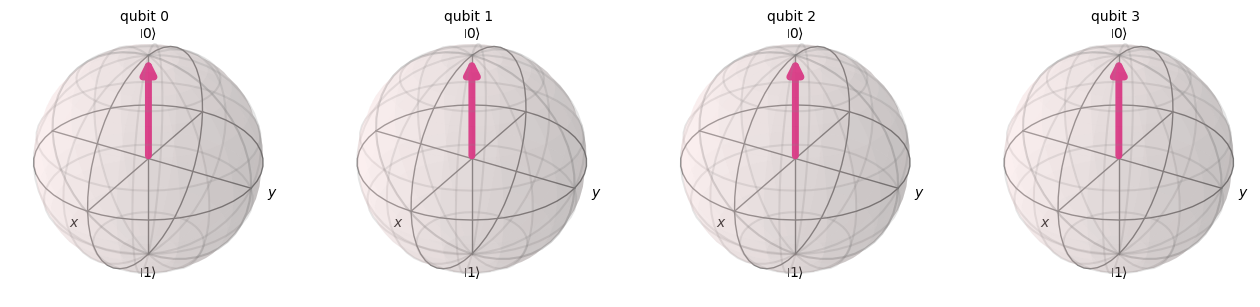

In [158]:
qr_eigenstate = QuantumRegister(eigen_bits)
qc = QuantumCircuit(qr_eigenstate)

# state preparation
if g >= 1:
    qc.h(qr_eigenstate)

sv = Statevector(qc)
print("ANSATZ:")
plot_bloch_multivector(sv)

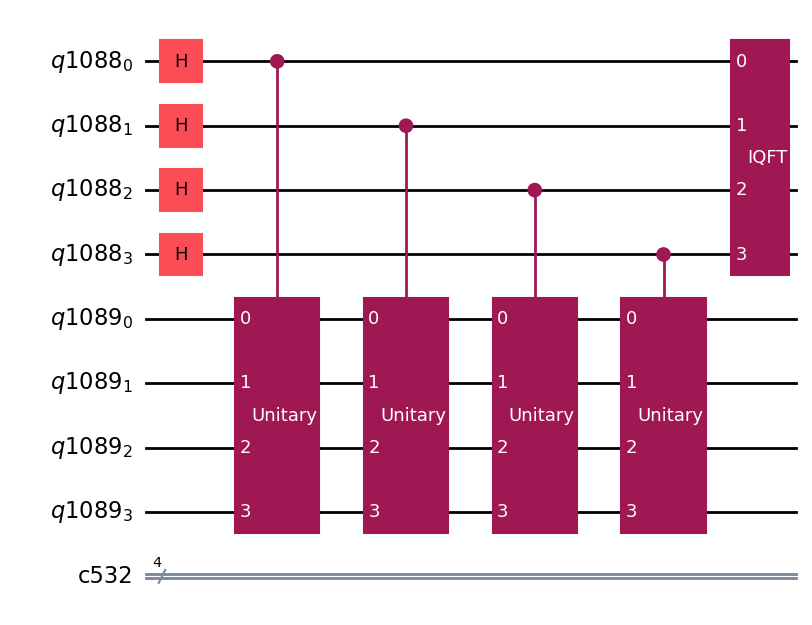

In [162]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# state perparation
qc.h(qr_ancilla)
if g >= 1:
    qc.h(qr_eigenstate)
#qc.x(qr_eigenstate[0])
#qc.x(qr_eigenstate[2])


for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
qc.draw('mpl')

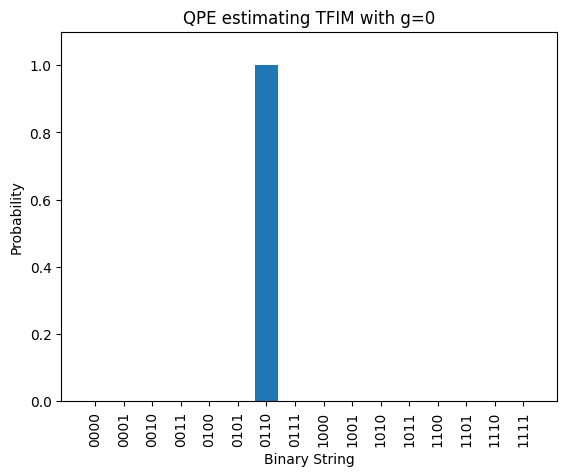

In [163]:
create_graph(qc, g)

In [164]:
get_phase_from(qc)

Binary Number Output: 0.0110
Decimal Number with Equivalent Value: 0.375


0.375

Notice how reguardless of how $g$ is changed, in every plot, the statevector with the greatest probability of success was indeed the vector that represented the ground energy state of the system, which means the QPE is able to successfully determine the ground state of the TFIM.

Notice specifically when $g$ is close to 1, the correct state ($0011$) has less of a probability to be measured than it would be in with a strong magnetic field ($g>>1$) or a large coupling term ($g\approx0$). This is because unlike the cases when $g\approx0$ or when $g>>1$, the system isn't as well defined, so the initial guess has some overlap with states that aren't representing the ground state of the system. In systems where states are close together, it gets harder to make a guess of what state will have the most overlap with the ground state. Thus whenever QPE is used a good understanding of what the system represents is required.